In [27]:
# import useful libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score


# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# import helper functions


In [28]:
data_folder = 'data'


def get_dataframes():
    train_X = pd.read_csv('../' + data_folder + '/' + 'train_X.csv')
    train_Y = pd.read_csv('../' + data_folder + '/' + 'train_y.csv')
    test_X = pd.read_csv('../' + data_folder + '/' + 'test_X.csv')
    test_Y = pd.read_csv('../' + data_folder + '/' + 'test_y.csv')
    return train_X, train_Y, test_X, test_Y


# import the test and train dataframes
train_X, train_Y, test_X, test_Y = get_dataframes()

train_X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 140398 entries, 0 to 140397
Data columns (total 40 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   heartrate         140398 non-null  float64
 1   handTemperature   140398 non-null  float64
 2   handAcc16_1       140398 non-null  float64
 3   handAcc16_2       140398 non-null  float64
 4   handAcc16_3       140398 non-null  float64
 5   handAcc6_1        140398 non-null  float64
 6   handAcc6_2        140398 non-null  float64
 7   handAcc6_3        140398 non-null  float64
 8   handGyro1         140398 non-null  float64
 9   handGyro2         140398 non-null  float64
 10  handGyro3         140398 non-null  float64
 11  handMagne1        140398 non-null  float64
 12  handMagne2        140398 non-null  float64
 13  handMagne3        140398 non-null  float64
 14  chestTemperature  140398 non-null  float64
 15  chestAcc16_1      140398 non-null  float64
 16  chestAcc16_2      14

In [29]:
import pickle
validation_k = 5
validation_scores = {}
c_values = [0.001, 0.01, 0.1, 1.0]
accuracies = {}
kernels = ['linear', 'poly', 'rbf', 'sigmoid']


def svm(train_X=train_X, train_Y=train_Y, test_X=test_X, test_Y=test_Y, isValidation=False, isSaveModel = False):
    best_accuracy = 0
    best_kernel = ''
    best_c = 0
    for kernel in kernels:
        if isValidation:
            # make pipeline
            train_score, test_score = validation_curve(
                SVC(), train_X, train_Y, param_name='C', param_range=c_values, cv=validation_k, scoring='accuracy')
            train_score_mean = np.mean(train_score, axis=1)
            test_score_mean = np.mean(test_score, axis=1)
            validation_dict = {}
            validation_dict['train_score_mean'] = train_score_mean
            validation_dict['test_score_mean'] = test_score_mean
            validation_scores[kernel] = validation_dict
            print('Validation scores for kernel ', kernel, ' are : ')
            print('Train score : ', train_score_mean)
            print('Test score : ', test_score_mean)
        else:
            for c in c_values:
                svm_model = SVC(kernel=kernel, C=c, gamma=1)
                svm_model.fit(train_X, train_Y)
                y_pred = svm_model.predict(test_X)
                accuracy = accuracy_score(test_Y, y_pred)
                accuracies[(c, kernel)] = accuracy
                if accuracy > best_accuracy:
                    best_accuracy = accuracy
                    best_c = c
                    best_kernel = kernel
                    if isSaveModel:
                        pickle.dump(svm_model, open(
                            '../models/svm_model.sav', 'wb'))
                print('Accuracy for C = ', c, 'and kernel : ',
                      kernel, ' is ', accuracy)

    if isValidation:
        return validation_scores
    else:
        return best_accuracy, best_c, best_kernel


In [30]:
def plot_accuracy_vs_c(kernels=kernels, c_values=c_values, accuracies=accuracies, title = ''):
    for kernel in kernels:
        accuracy_vs_c = []
        for c in c_values:
            accuracy_vs_c.append(accuracies[(c, kernel)])
        plt.plot(c_values, accuracy_vs_c, label=kernel)
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.title(title)
    plt.legend()
    plt.show()


### Plotting accuracy for a range of c values for kernels (poly, sigmoid, linear, rbf), for a subset of data

Accuracy for C =  0.001 and kernel :  linear  is  0.785
Accuracy for C =  0.01 and kernel :  linear  is  0.8
Accuracy for C =  0.1 and kernel :  linear  is  0.79
Accuracy for C =  1.0 and kernel :  linear  is  0.805
Accuracy for C =  0.001 and kernel :  poly  is  0.865
Accuracy for C =  0.01 and kernel :  poly  is  0.865
Accuracy for C =  0.1 and kernel :  poly  is  0.865
Accuracy for C =  1.0 and kernel :  poly  is  0.865
Accuracy for C =  0.001 and kernel :  rbf  is  0.12
Accuracy for C =  0.01 and kernel :  rbf  is  0.12
Accuracy for C =  0.1 and kernel :  rbf  is  0.12
Accuracy for C =  1.0 and kernel :  rbf  is  0.15
Accuracy for C =  0.001 and kernel :  sigmoid  is  0.12
Accuracy for C =  0.01 and kernel :  sigmoid  is  0.12
Accuracy for C =  0.1 and kernel :  sigmoid  is  0.12
Accuracy for C =  1.0 and kernel :  sigmoid  is  0.12
Best accuracy:  0.865
Best C:  0.001
Best kernel:  poly


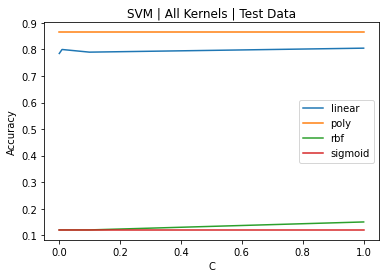

In [31]:
best_accuracy, best_c, best_kernel = svm(train_X=train_X[:2000], train_Y=train_Y[:2000],
                                         test_X=test_X[:200], test_Y=test_Y[:200], isValidation=False)

print('Best accuracy: ', best_accuracy)
print('Best C: ', best_c)
print('Best kernel: ', best_kernel)

# plot 3 line graphs for accuracy vs C for each kernel

plot_accuracy_vs_c(title='SVM | All Kernels | Test Data')


We see that the rbf and sigmoid kernels do not report significant accuracies, thus we drop them and proceed with a larger subset of data

Accuracy for C =  0.001 and kernel :  linear  is  0.8345
Accuracy for C =  0.01 and kernel :  linear  is  0.871
Accuracy for C =  0.1 and kernel :  linear  is  0.87
Accuracy for C =  1.0 and kernel :  linear  is  0.873
Accuracy for C =  0.001 and kernel :  poly  is  0.9475
Accuracy for C =  0.01 and kernel :  poly  is  0.9475
Accuracy for C =  0.1 and kernel :  poly  is  0.9475
Accuracy for C =  1.0 and kernel :  poly  is  0.9475
Best accuracy:  0.9475
Best C:  0.001
Best kernel:  poly


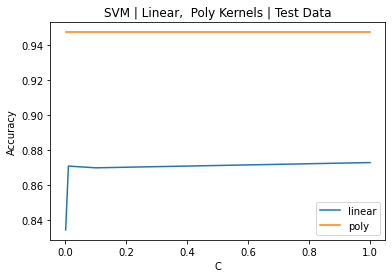

In [32]:
kernels = ['linear', 'poly']
best_accuracy, best_c, best_kernel = svm(train_X=train_X[:20000], train_Y=train_Y[:20000],
                                         test_X=test_X[:2000], test_Y=test_Y[:2000], isValidation=False)

print('Best accuracy: ', best_accuracy)
print('Best C: ', best_c)
print('Best kernel: ', best_kernel)

# plot 3 line graphs for accuracy vs C for each kernel

plot_accuracy_vs_c(kernels=kernels, c_values=c_values,
                   title='SVM | Linear,  Poly Kernels | Test Data')


VALIDATION CURVE FOR BEST KERNEL 

Validation scores for kernel  poly  are : 
Train score :  [0.1281    0.5658625 0.748775  0.8499375]
Test score :  [0.1281  0.56555 0.74615 0.84155]


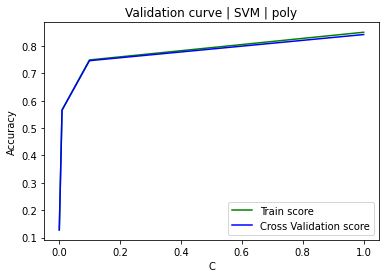

In [33]:
# get the validation scores for best kernel   (ONLY FOR BEST KERNEL)
kernels = [best_kernel]
# validation score using full training set
validation_scores = svm(train_X=train_X[:20000], train_Y=train_Y[:20000],
                        test_X=test_X[:2000], test_Y=test_Y[:2000], isValidation=True)
# plot the validation scores for each C for best kernel


def plot_validation_scores():
    plt.plot(c_values, validation_scores[best_kernel]
             ['train_score_mean'], color='green', label='Train score')
    plt.plot(c_values, validation_scores[best_kernel]
             ['test_score_mean'], color='blue', label='Cross Validation score')
    plt.title('Validation curve | SVM | ' + best_kernel)
    plt.xlabel('C')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')
    plt.show()


plot_validation_scores()


### Using Full Dataset to store model and find accuracy for best C and kernel

In [34]:
kernels = [best_kernel]
c_values = [0.01]

best_accuracy, best_c, best_kernel = svm(isValidation=False, isSaveModel=True)
print('Best accuracy: ', best_accuracy)
print('Best C: ', best_c)
print('Best kernel: ', best_kernel)


Accuracy for C =  0.01 and kernel :  poly  is  0.9794586894586894
Best accuracy:  0.9794586894586894
Best C:  0.01
Best kernel:  poly


In [35]:

def load_model_predict():
    loaded_model = pickle.load(open('../models/svm_model.sav', 'rb'))
    result = loaded_model.score(test_X, test_Y)
    print("Accuracy for SVM model: ", result)


load_model_predict()


Accuracy for SVM model:  0.9794586894586894
